Imports

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Load Dataset

Kaggle link: https://www.kaggle.com/datasets/uldisvalainis/audio-emotions

In [15]:
# Update to load files directly from the audio folder categorized by emotions
root_audio_folder = "Emotions/"
labels = []
file_paths = []

# Iterate through the audio folders (each representing an emotion) and extract file paths and labels
for emotion_folder in os.listdir(root_audio_folder):
    emotion_folder_path = os.path.join(root_audio_folder, emotion_folder)
    if os.path.isdir(emotion_folder_path):
        for file_name in os.listdir(emotion_folder_path):
            if file_name.endswith(".wav"):
                file_paths.append(os.path.join(emotion_folder_path, file_name))
                labels.append(emotion_folder)

Pre-process Audio Data - Convert audio files to Mel Spectrograms

In [16]:
def create_mel_spectrogram(file_path, n_mels=128, max_len=130):
    y, sr = librosa.load(file_path, duration=3.0)  # Loading the audio
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if mel_spectrogram.shape[1] < max_len:
        pad_width = max_len - mel_spectrogram.shape[1]
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_len]
    return mel_spectrogram

# Extracting features and labels
mel_spectrograms = []

for file_path in file_paths:
    if os.path.exists(file_path):
        mel_spectrogram = create_mel_spectrogram(file_path)
        mel_spectrograms.append(mel_spectrogram)

Convert features and labels to NumPy Arrays

In [17]:
mel_spectrograms = np.array([np.expand_dims(mel, axis=-1) for mel in mel_spectrograms])
labels = np.array(labels)

Encode Labels

In [18]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mel_spectrograms, labels_encoded, test_size=0.2, random_state=42)

## CNN Model Creation

In [20]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 130, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

normal_cnn_history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

eval_results = cnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")


c:\Users\eyad_\Desktop\Machine Learning CW\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 35s 107ms/step - accuracy: 0.1950 - loss: 16.7390 - val_accuracy: 0.2102 - val_loss: 1.8695
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.2432 - loss: 1.8173 - val_accuracy: 0.3902 - val_loss: 1.5281
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.4110 - loss: 1.4712 - val_accuracy: 0.4453 - val_loss: 1.3656
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 34s 105ms/step - accuracy: 0.4464 - loss: 1.3548 - val_accuracy: 0.4801 - val_loss: 1.2810
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.4886 - loss: 1.2687 - val_accuracy: 0.5031 - val_loss: 1.2208
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.5213 - loss: 1.2013 - val_accuracy: 0.5238 - val_loss: 1.1714
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.5426 - loss: 1.1466 - val_accuracy: 0.5293 - val_loss: 1.1447
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.5767 - loss: 

In [22]:
cnn_model.save('cnn.keras')

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.67      0.69       433
           1       0.54      0.37      0.44       391
           2       0.56      0.52      0.54       416
           3       0.61      0.57      0.59       428
           4       0.57      0.68      0.62       371
           5       0.51      0.67      0.58       402
           6       0.94      0.87      0.90       119

    accuracy                           0.60      2560
   macro avg       0.63      0.62      0.62      2560
weighted avg       0.60      0.60      0.59      2560



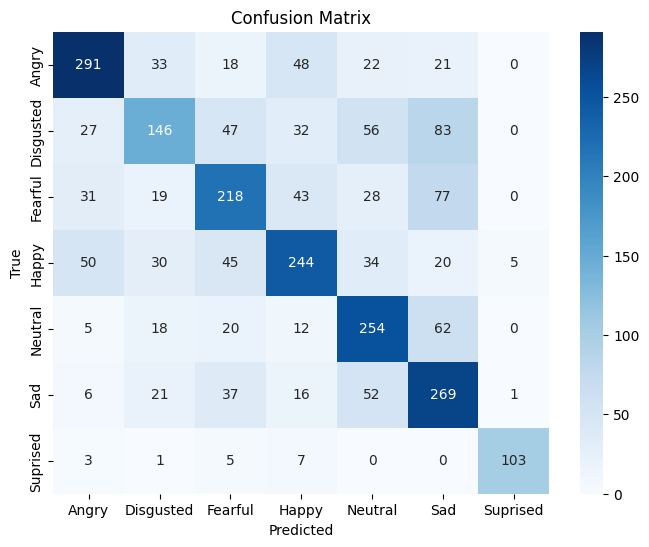

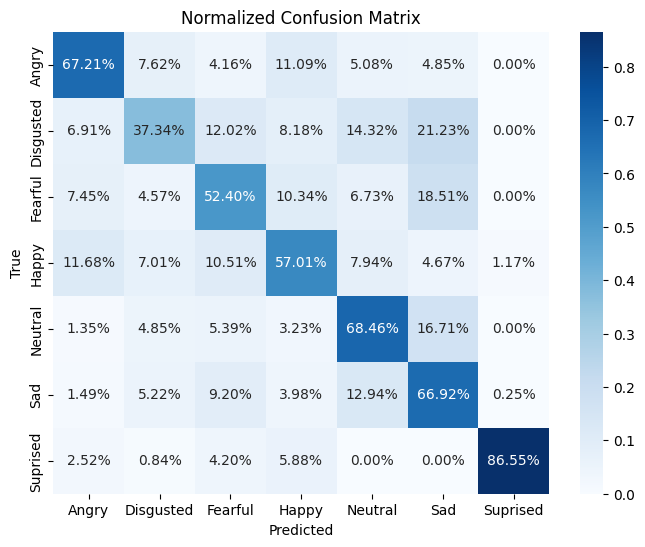

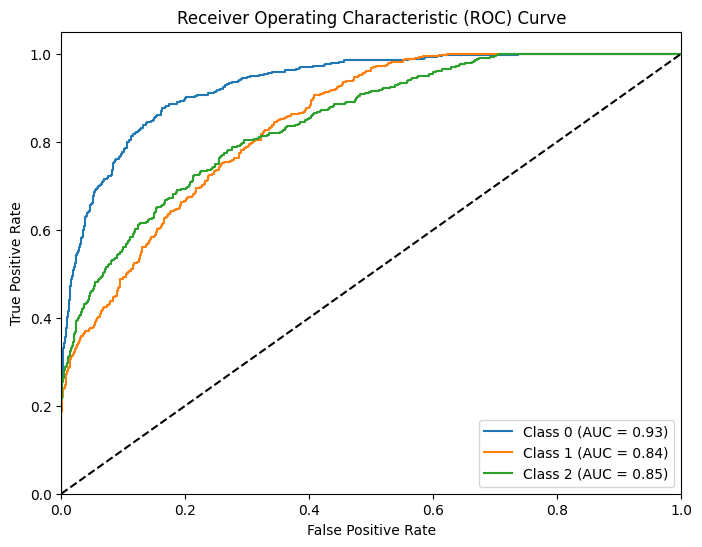

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Predictions
y_pred = cnn_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Define class names from label encoder
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()


# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




Plot Receiver Operating Characteristic (ROC) Curve

## RNN Model with LSTM

In [24]:

from tensorflow.keras.layers import LSTM, Embedding

# Building the RNN model (LSTM)
rnn_model = Sequential()
rnn_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dropout(0.3))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the RNN model
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the RNN model
rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


c:\Users\eyad_\Desktop\Machine Learning CW\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.1846 - loss: 1.9160 - val_accuracy: 0.2156 - val_loss: 1.8646
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.2167 - loss: 1.8596 - val_accuracy: 0.2121 - val_loss: 1.8304
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.2251 - loss: 1.8311 - val_accuracy: 0.2301 - val_loss: 1.8179
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.2347 - loss: 1.8286 - val_accuracy: 0.2551 - val_loss: 1.7771
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.2300 - loss: 1.8102 - val_accuracy: 0.2441 - val_loss: 1.7851
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.2268 - loss: 1.8114 - val_accuracy: 0.2539 - val_loss: 1.7735
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.2384 - loss: 1.7998 - val_accuracy: 0.2578 - val_loss: 1.7617
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.2447 - loss: 1.7984 - val_acc

In [25]:
rnn_model.save('rnn.keras')

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.42      0.07      0.12       433
           1       0.00      0.00      0.00       391
           2       0.80      0.10      0.17       416
           3       0.33      0.33      0.33       428
           4       1.00      0.15      0.26       371
           5       0.19      0.92      0.31       402
           6       0.00      0.00      0.00       119

    accuracy                           0.25      2560
   macro avg       0.39      0.22      0.17      2560
weighted avg       0.43      0.25      0.19      2560



c:\Users\eyad_\Desktop\Machine Learning CW\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eyad_\Desktop\Machine Learning CW\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eyad_\Desktop\Machine Learning CW\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

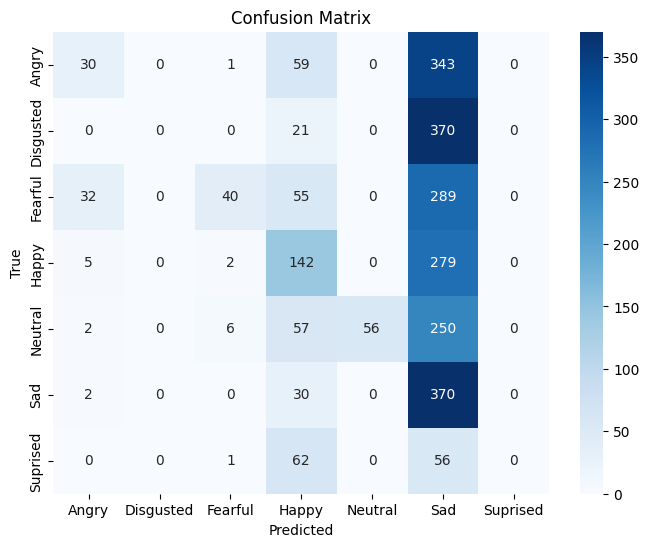

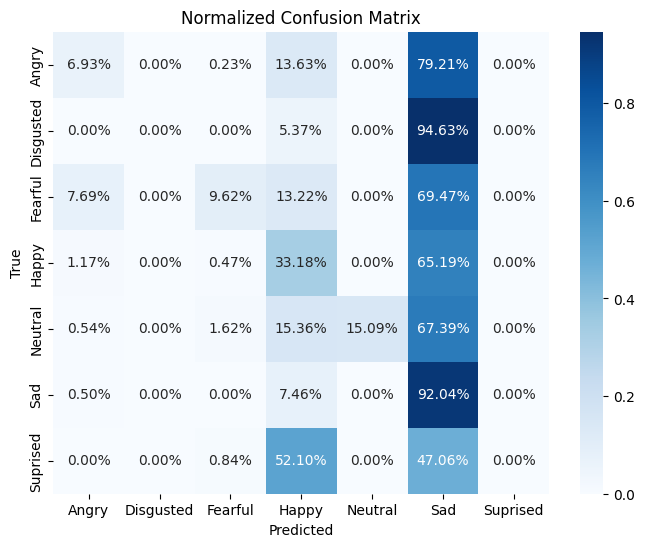

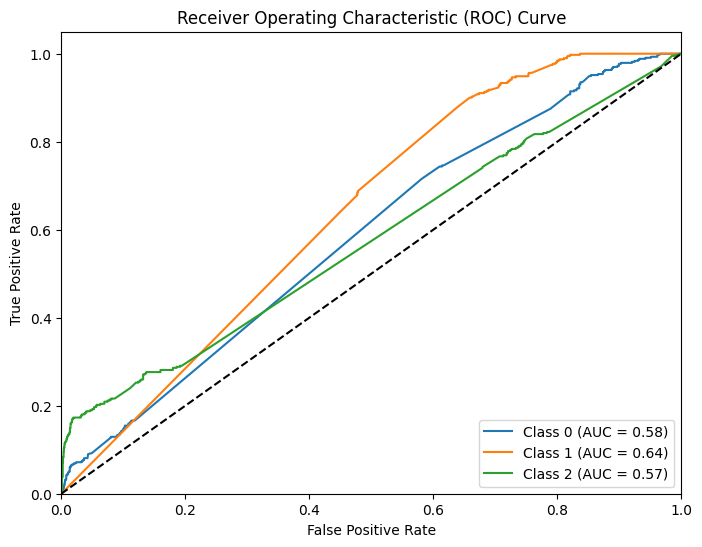

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

y_pred = rnn_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Define class names from label encoder
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()



# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




## SVM Model for Sentiment Analysis

In [26]:

from sklearn import svm
from sklearn.metrics import accuracy_score

# Flatten data for SVM (since SVM does not accept 3D input like neural networks)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train the SVM model
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train_flat, y_train)

# Evaluate the SVM model
y_pred_svm = svm_model.predict(X_test_flat)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Model Accuracy: {svm_accuracy * 100:.2f}%")


SVM Model Accuracy: 55.51%


In [ ]:
import joblib

# Save the model
joblib.dump(svm_model, 'svm_model.keras')

['svm_model.keras']

Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.69      0.64       433
           1       0.48      0.51      0.50       391
           2       0.44      0.46      0.45       416
           3       0.56      0.51      0.53       428
           4       0.58      0.50      0.54       371
           5       0.58      0.56      0.57       402
           6       0.82      0.87      0.84       119

    accuracy                           0.56      2560
   macro avg       0.58      0.58      0.58      2560
weighted avg       0.56      0.56      0.55      2560



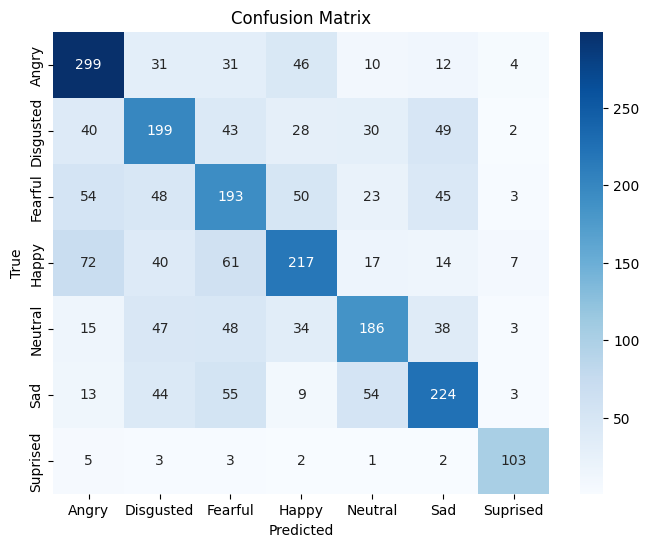

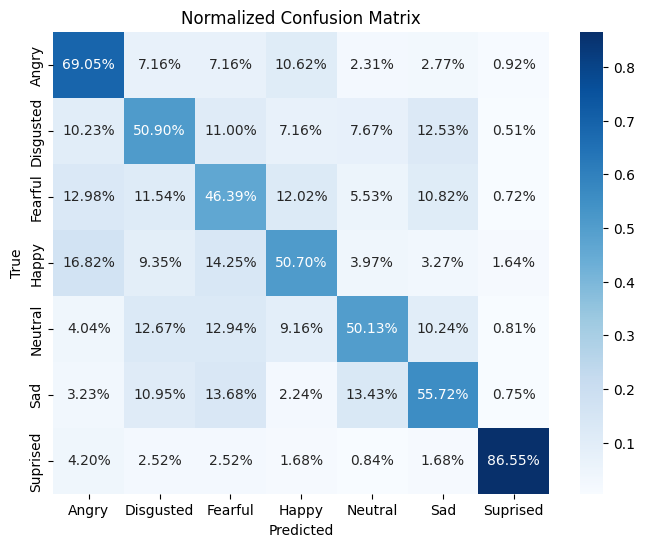

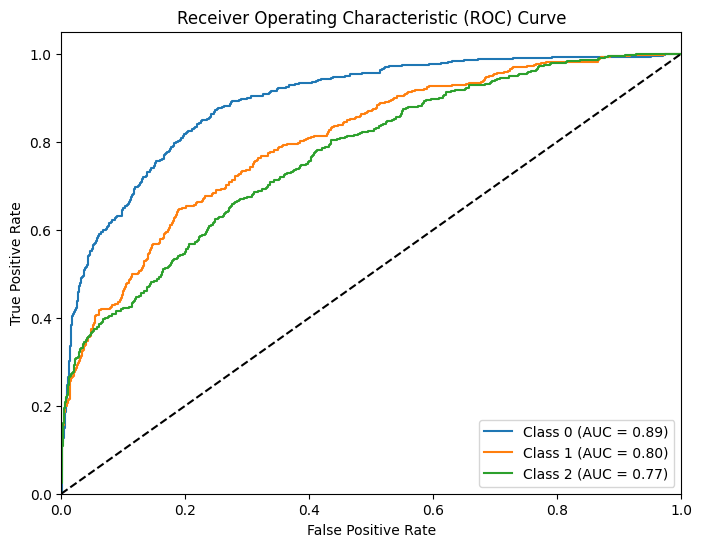

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Flatten the test data
y_pred_classes = svm_model.predict(X_test_flat)
y_pred = svm_model.decision_function(X_test_flat)  # Get decision function scores for ROC curve

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Define class names from label encoder
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()



# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




## Performance Comparison

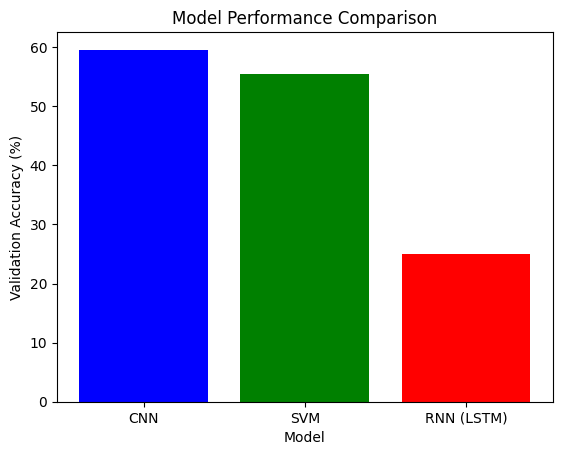

In [34]:

import matplotlib.pyplot as plt

# Plotting accuracy comparison
cnn_accuracy = normal_cnn_history.history['val_accuracy'][-1] * 100
rnn_accuracy = rnn_history.history['val_accuracy'][-1] * 100

models = ['CNN', 'SVM', 'RNN (LSTM)']
accuracies = [cnn_accuracy, svm_accuracy * 100, rnn_accuracy]

plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Validation Accuracy (%)')
plt.title('Model Performance Comparison')
plt.show()


## Fine-tuned CNN Model

In [ ]:
# Fine-tuned CNN model with further improvements for better performance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D

# Fine-tuned CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 130, 1), padding='same'),
    BatchNormalization(),  # Added Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Increased Dropout to prevent overfitting

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),  # Added Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.4),  # Increased Dropout

    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Added additional convolutional layer for more complexity
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Added more filters for higher complexity
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    GlobalAveragePooling2D(),  # Replaced Flatten with Global Average Pooling for better generalization
    Dense(512, activation='relu'),  # Increased Dense layer size for better feature extraction
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
cnn_history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=32,
)

# Evaluate the model
eval_results = model.evaluate(X_test, y_test)
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")


Epoch 1/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 73s 222ms/step - accuracy: 0.2657 - loss: 2.1374 - val_accuracy: 0.2363 - val_loss: 2.9910
Epoch 2/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 217ms/step - accuracy: 0.4202 - loss: 1.5213 - val_accuracy: 0.2746 - val_loss: 3.9767
Epoch 3/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 218ms/step - accuracy: 0.4746 - loss: 1.3424 - val_accuracy: 0.3832 - val_loss: 1.8431
Epoch 4/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 217ms/step - accuracy: 0.5200 - loss: 1.2291 - val_accuracy: 0.2941 - val_loss: 5.5290
Epoch 5/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 71s 221ms/step - accuracy: 0.5570 - loss: 1.1388 - val_accuracy: 0.2953 - val_loss: 2.7552
Epoch 6/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 219ms/step - accuracy: 0.5830 - loss: 1.0815 - val_accuracy: 0.4641 - val_loss: 2.2795
Epoch 7/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 219ms/step - accuracy: 0.5853 - loss: 1.0540 - val_accuracy: 0.2781 - val_loss: 3.1439
Epoch 8/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 217ms/step - accuracy: 0.6024 - loss: 1

In [13]:
model.save('fine_tuned_cnn.keras')

80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.59      0.73       433
           1       0.82      0.65      0.73       391
           2       0.57      0.80      0.66       416
           3       0.77      0.61      0.68       428
           4       0.65      0.91      0.75       371
           5       0.67      0.70      0.69       402
           6       0.95      0.94      0.95       119

    accuracy                           0.72      2560
   macro avg       0.77      0.74      0.74      2560
weighted avg       0.75      0.72      0.72      2560



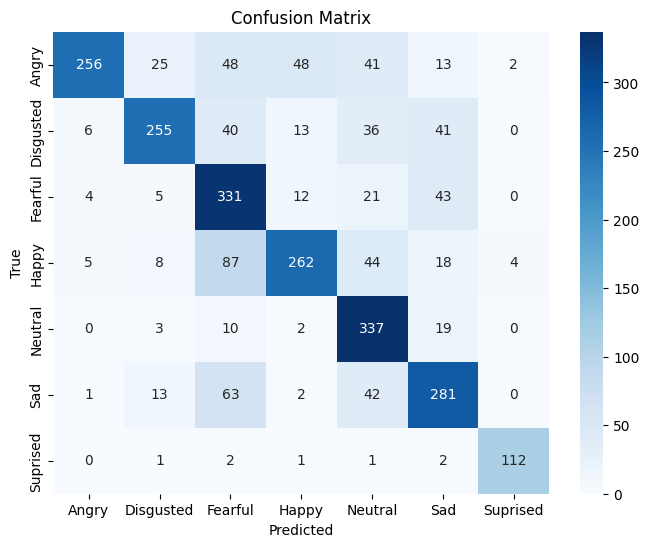

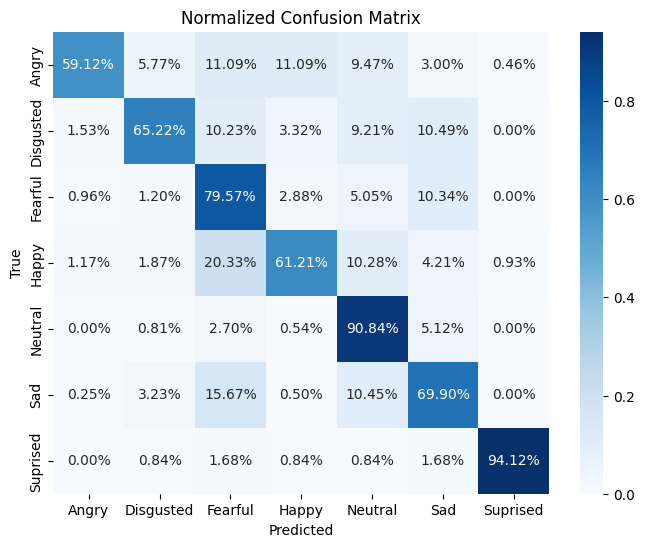

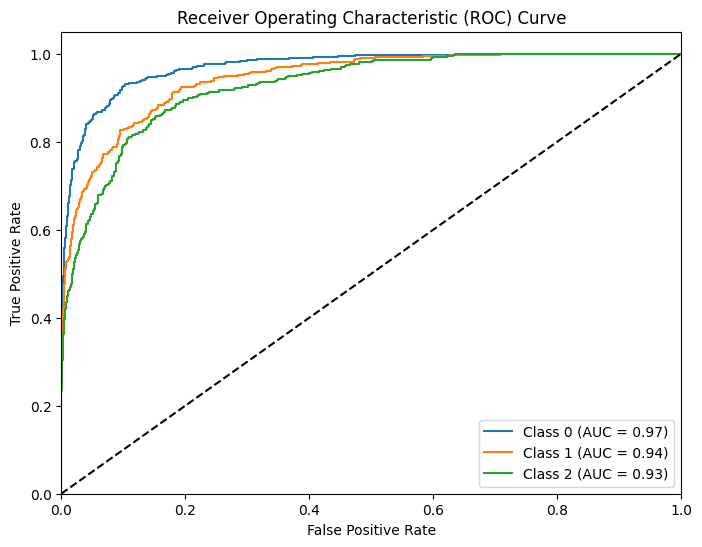

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Define class names from label encoder
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()


# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




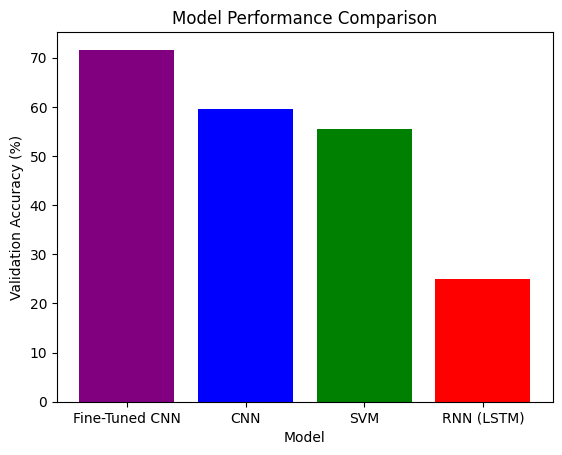

In [35]:

import matplotlib.pyplot as plt

# Plotting accuracy comparison
finetuned_cnn_accuracy = cnn_history.history['val_accuracy'][-1] * 100
normal_cnn_accuracy = normal_cnn_history.history['val_accuracy'][-1] * 100
rnn_accuracy = rnn_history.history['val_accuracy'][-1] * 100

models = ['Fine-Tuned CNN','CNN', 'SVM', 'RNN (LSTM)']
accuracies = [finetuned_cnn_accuracy,cnn_accuracy, svm_accuracy * 100, rnn_accuracy]

plt.bar(models, accuracies, color=['purple','blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Validation Accuracy (%)')
plt.title('Model Performance Comparison')
plt.show()
